# Prior-posterior comparison figures notebook

## Package import

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
from cycler import cycler

import scipy.stats as stats
from scipy.stats import gaussian_kde
from scipy.special import rel_entr
import netCDF4 as nc4
import numpy as np

## Main parameters

In [2]:
# netCDF input file
input_name = '../results/zinser_results_full.nc'

# save generated plots
save_plots = False

# the datafile used for model fitting
datafile = '../data/size_distribution/zinser_processed.nc'

# time discretization parameter used in model fitting (in units of minutes)
dt = 20

## Prior distribution info

The dictionary `prior_distribution_info` contains information about the models and the prior distributions of their parameters that are used for plotting. If these are changed in the code, they need to be changed here as well.

In [3]:
with nc4.Dataset(datafile) as nc:
    data_gridded = {var: nc.variables[var][:] for var in nc.variables}

delta_v = 1.0/data_gridded['delta_v_inv']
dt_days = dt/1440.0
dt_norm = dt/(1440.0 * (2**delta_v - 1.0))

prior_distribution_info = {
    'm_bmb': {
        'delta_max': {'dist': 'stan-default-bounded', 'lower_limit': 0.0, 'upper_limit': 1.0/dt_days},
        'gamma_max': {'dist': 'normal', 'params': (10.0, 10.0), 'lower_limit': 0.0, 'upper_limit': 1.0/dt_norm},
        'rho_max': {'dist': 'normal', 'params': (3.0, 10.0), 'lower_limit': 0.0, 'upper_limit': 1.0/dt_norm},
        'E_star': {'dist': 'normal', 'params': (1000.0, 1000.0), 'lower_limit': 0.0},
        #'sigma': {'dist': 'stan-default'},
        #'w_ini': {'dist': 'stan-default-simplex', 'index':[4, 9, 14, 19, 24], 'plot_upper_limit': 0.25},
        #'delta_incr': {'dist': 'stan-default-simplex', 'index':[4, 9, 14], 'plot_upper_limit': 0.6},    
    },
    'm_ftf': {
        'delta_max': {'dist': 'stan-default-bounded', 'lower_limit': 0.0, 'upper_limit': 1.0/dt_days},
        'gamma_mu': {'dist': 'normal', 'params': (10.0, 10.0), 'lower_limit': 0.0, 'upper_limit': 1.0/dt_norm},
        'gamma_sigma': {'dist': 'exponential', 'params': (0.1,)},
        'rho_mu': {'dist': 'normal', 'params': (3.0, 10.0), 'lower_limit': 0.0, 'upper_limit': 1.0/dt_norm},
        'rho_sigma': {'dist': 'exponential', 'params': (0.1,)},
        'E_star': {'dist': 'normal', 'params': (1000.0, 1000.0), 'lower_limit': 0.0},
    },
}

parameter_names = {
    'delta_max': '$\\delta_{max}$',
    'gamma_max': '$\\gamma_{max}$',
    'gamma_mu': '$\\mu_{\\gamma}$',
    'gamma_sigma': '$\\sigma_{\\gamma}$',
    'rho_max': '$\\rho_{max}$',
    'rho_mu': '$\\mu_{\\rho}$',
    'rho_sigma': '$\\sigma_{\\rho}$',
    'E_star': 'E$_{k}$',
    'sigma': '$\\sigma$',
    'w_ini': '$w(0)^{{({index})}}$',
    'delta_incr': '$\\delta_{{incr}}^{{({index})}}$',
}

## Load Results

In [4]:
with nc4.Dataset(input_name) as nc:
    mcmc = {model: {var: nc[model][var][:] for var in prior_distribution_info[model]} for model in prior_distribution_info}
    
# set model name
model_names = {
    'm_bmx': 'm$_\mathrm{bmx}$',
    'm_bmb': 'm$_\mathrm{bmb}$',
    'm_pmb': 'm$_\mathrm{pmb}$',
    'm_fmb': 'm$_\mathrm{fmb}$',
    'm_fmf': 'm$_\mathrm{fmf}$',
    'm_btb': 'm$_\mathrm{btb}$', 
    'm_ptb': 'm$_\mathrm{ptb}$', 
    'm_ftb': 'm$_\mathrm{ftb}$',
    'm_ftf': 'm$_\mathrm{ftf}$',
}

## Helper functions

In [5]:
def empirical_kldiv(posterior_samples, prior_pdf, num=300):
    x = np.linspace(np.min(posterior_samples), np.max(posterior_samples), num)
    
    px = gaussian_kde(posterior_samples)(x)
    qx = prior_pdf(x)
    
    return np.trapz(x=x, y=rel_entr(px, qx))

## Some Plotting Parameters

In [6]:
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['axes.titlesize'] = 9
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.prop_cycle'] = cycler(color=('#DDAA33', '#004488', '#BB5566'))
mpl.rcParams['grid.color'] = 'grey'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.3
mpl.rcParams['mathtext.default'] = 'regular'

path_effects = [pe.Stroke(linewidth=1, foreground='w'), pe.Normal()]

# Figures

### Prior-posterior comparison plots 

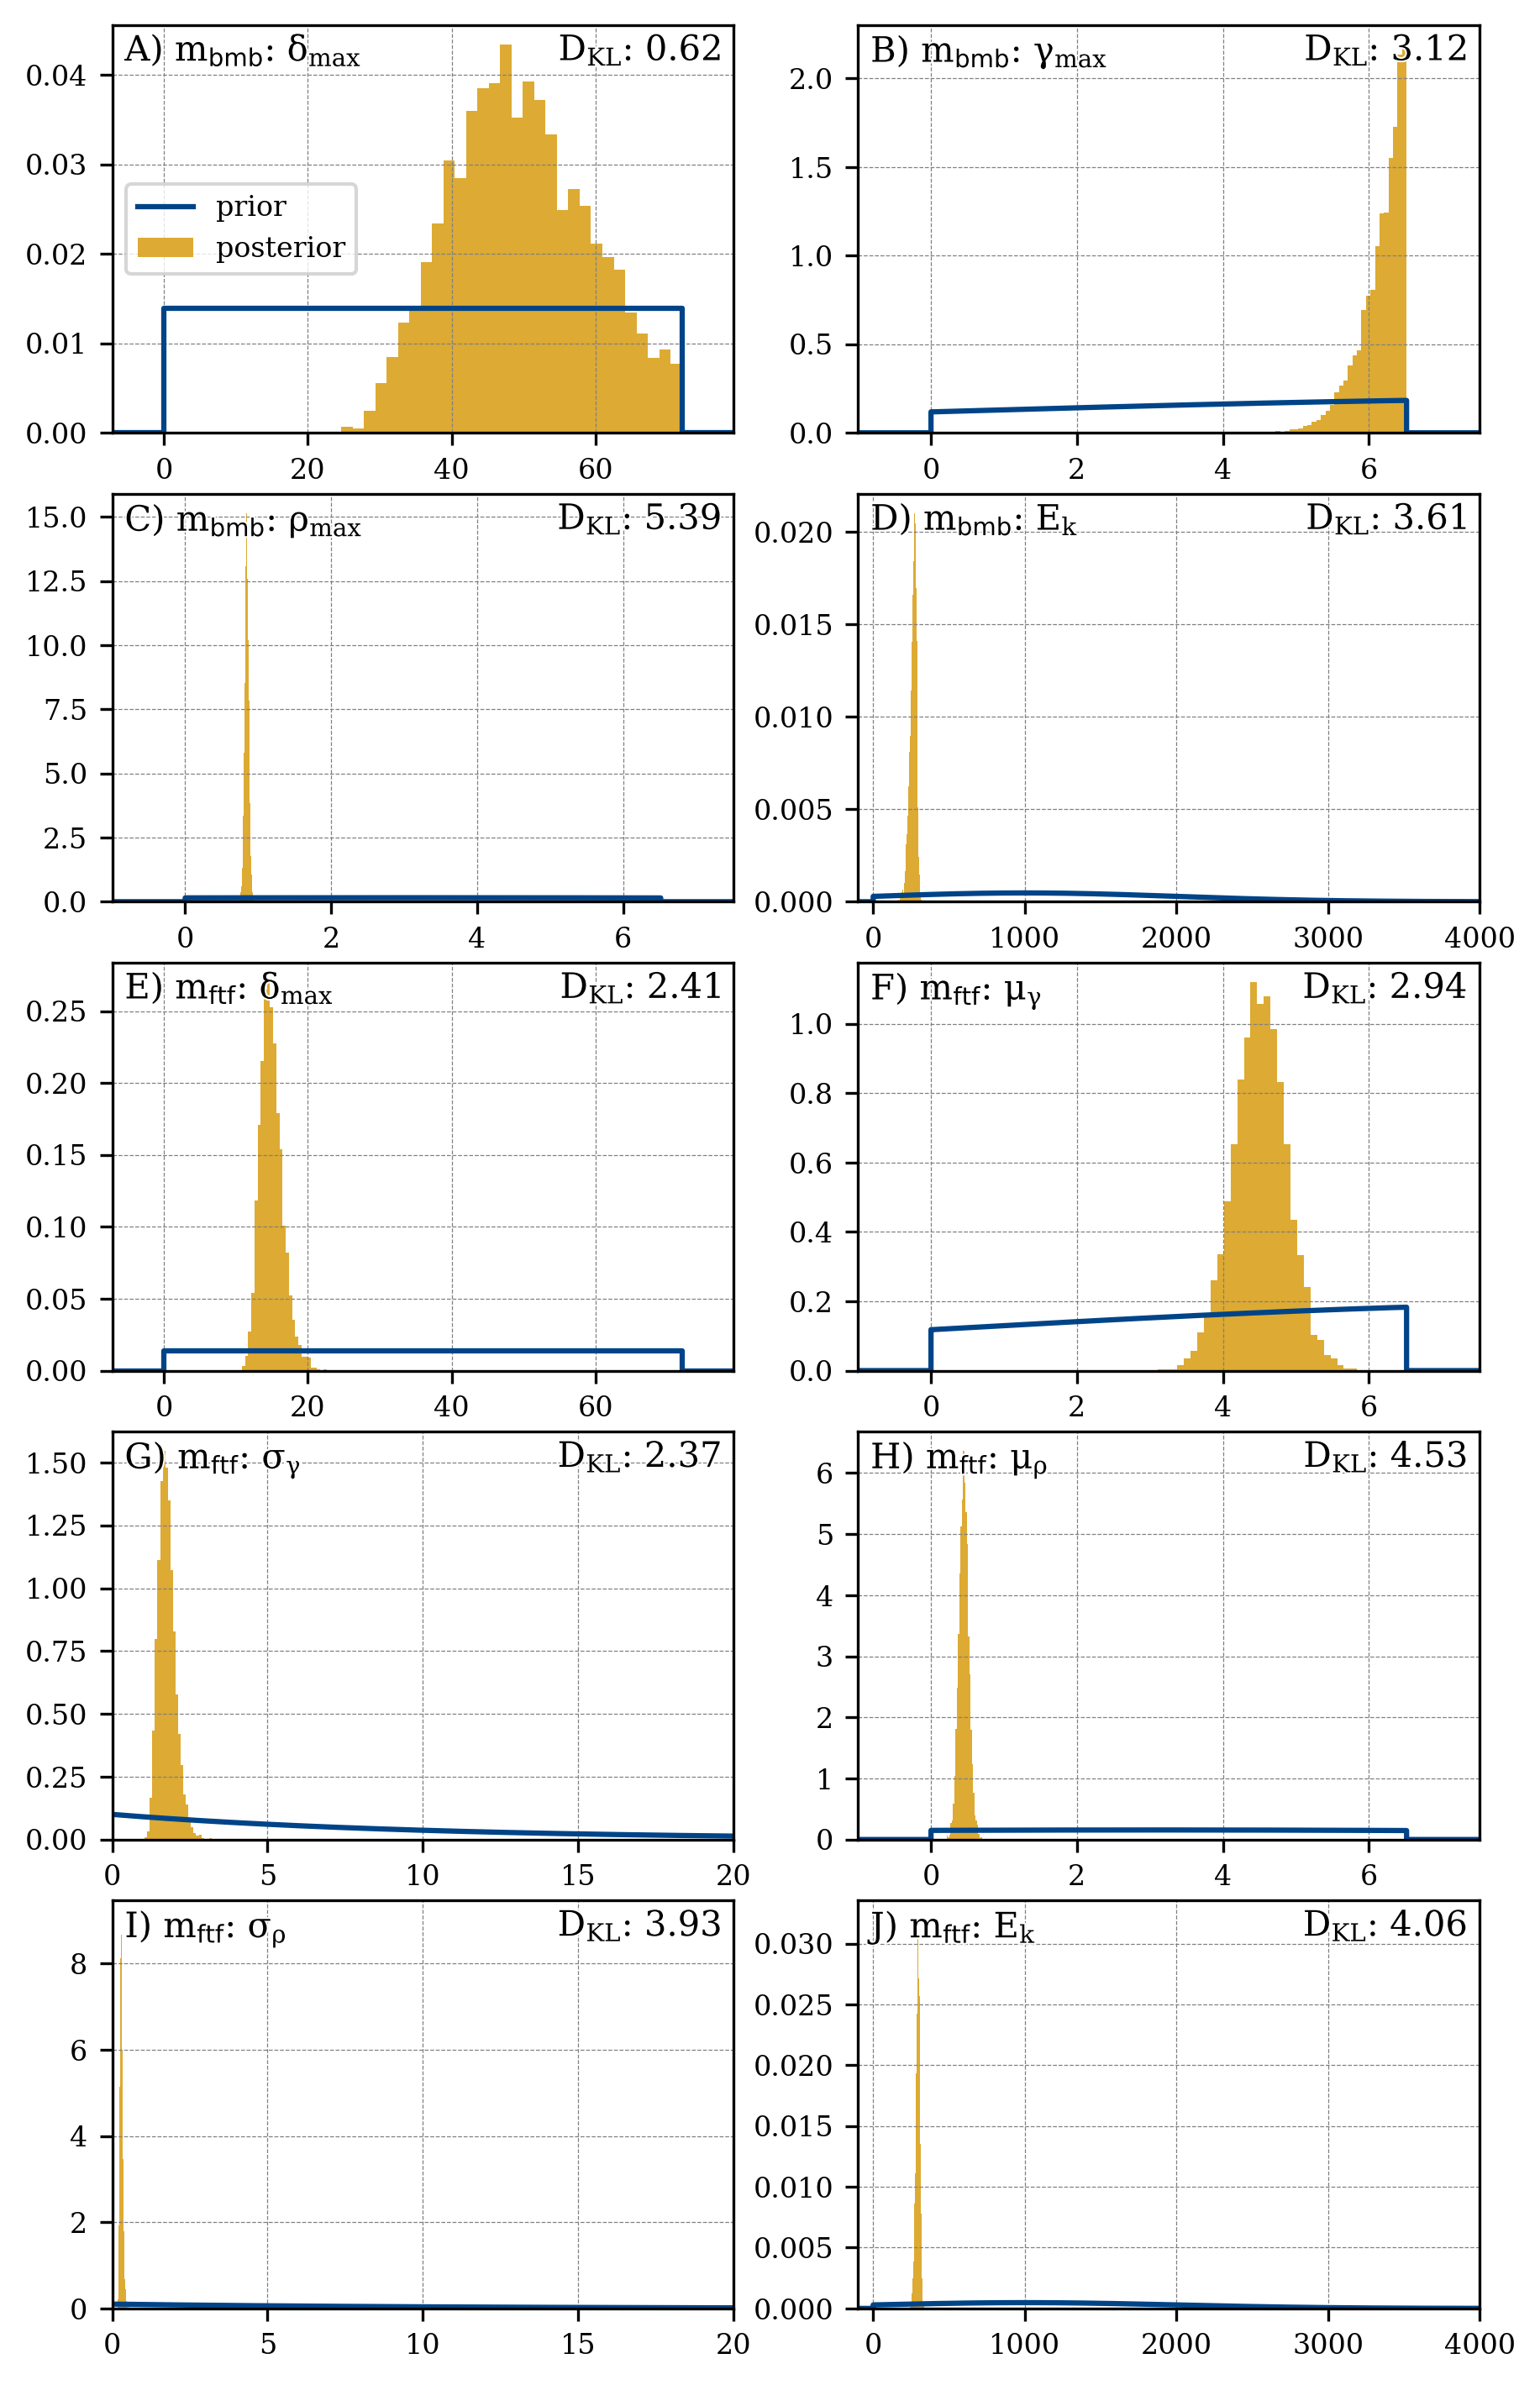

In [7]:
add_labels=True

nplots = 0
for model in prior_distribution_info:
    for param in prior_distribution_info[model]:
        if 'index' in prior_distribution_info[model][param]:
            nplots += len(prior_distribution_info[model][param]['index'])
        else:
            nplots += 1

ncols = 2      
nrows = int(np.ceil(nplots/ncols))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5*ncols, 2.4*nrows), 
                        gridspec_kw={'hspace': 0.15})
for ax in axs.flat:
    ax.set_visible(False)

axs_flat = axs.flat
i = -1
for model in prior_distribution_info:
    for param in prior_distribution_info[model]:
        distinfo = prior_distribution_info[model][param]
        if 'index' in distinfo:
            indices = distinfo['index']
        else:
            indices = [0]
        for index in indices:
            i += 1
            ax = axs_flat.__next__()
            ax.set_visible(True)

            if mcmc[model][param].ndim > 1:
                posterior_samples = mcmc[model][param][:,index]
            else:
                posterior_samples = mcmc[model][param]

            if distinfo['dist'] == 'stan-default-simplex':
                if 'plot_upper_limit' in distinfo:
                    ax.hist(posterior_samples, bins=np.linspace(0, distinfo['plot_upper_limit'],
                                                                30), density=True, label='posterior')
                else:
                    ax.hist(posterior_samples, bins=np.linspace(0, 1.0, 30), density=True, label='posterior')
            else:
                ax.hist(posterior_samples, bins=30, density=True, label='posterior')

            xlim = np.asarray(ax.get_xlim())

            kldiv = None
            if 'dist' in distinfo:
                if distinfo['dist'] == 'normal':
                    mu, sigma = distinfo['params']
                    x_min = mu - 3 * sigma
                    x_max = mu + 3 * sigma
                    if 'lower_limit' in distinfo:
                        x_min = distinfo['lower_limit'] - 0.1 * sigma
                    if 'upper_limit' in distinfo:
                        x_max = distinfo['upper_limit'] + 0.1 * sigma

                    x = np.linspace(x_min, x_max, 200)
                    y = stats.norm.pdf(x, loc=mu, scale=sigma)
                    if 'lower_limit' in distinfo:
                        x0 = distinfo['lower_limit']
                        ind = x > x0
                        x = np.concatenate([[x_min, x0, x0], x[ind]])
                        y = np.concatenate([[0, 0, y[ind][0]], y[ind]])
                    if 'upper_limit' in distinfo:
                        x0 = distinfo['upper_limit']
                        ind = x < x0
                        x = np.concatenate([x[ind], [x0, x0, x_max]])
                        y = np.concatenate([y[ind], [y[ind][-1], 0, 0]])
                    y /= np.sum(np.trapz(y, x=x))

                    assert np.abs(np.sum(np.trapz(y, x=x)) - 1.0) < 0.01

                    ax.plot(x, y, label='prior')

                    kldiv = empirical_kldiv(posterior_samples, lambda x: stats.norm.pdf(x, loc=mu, scale=sigma))
                elif distinfo['dist'] == 'uniform':
                    a, b = distinfo['params']
                    h = 1.0/(b - a)
                    x_min = a - 0.1 * (b - a)
                    x_max = b + 0.1 * (b - a)
                    ax.plot([x_min, a, a, b, b, x_max], [0, 0, h, h, 0, 0], label='prior')

                    kldiv = empirical_kldiv(posterior_samples, lambda x: stats.uniform.pdf(x, a, b))
                elif distinfo['dist'] == 'exponential':
                    lam = distinfo['params'][0]
                    x_min = 0.0
                    x_max = 2.0/lam

                    x = np.linspace(x_min, x_max, 200)
                    y = stats.expon.pdf(x, scale=1/lam)
                    ax.plot(x, y, label='prior')

                    kldiv = empirical_kldiv(posterior_samples, lambda x: stats.expon.pdf(x, scale=1/lam))
                elif distinfo['dist'] == 'stan-default-bounded':
                    a = distinfo['lower_limit']
                    b = distinfo['upper_limit']
                    h = 1.0/(b - a)
                    x_min = a - 0.1 * (b - a)
                    x_max = b + 0.1 * (b - a)
                    ax.plot([x_min, a, a, b, b, x_max], [0, 0, h, h, 0, 0], label='prior')

                    kldiv = empirical_kldiv(posterior_samples, lambda x: stats.uniform.pdf(x, a, b))
                elif distinfo['dist'] == 'stan-default-simplex':
                    x_min = 0.0
                    x_max = 1.0
                    if 'plot_upper_limit' in distinfo:
                        x_max = distinfo['plot_upper_limit']

                    # marginal of a Dirichlet is a beta distribution
                    x = np.linspace(x_min, x_max, 200)
                    y = stats.beta.pdf(x, 1.0, mcmc[model][param].shape[1] - 1.0)
                    ax.plot(x, y, label='prior')
                elif distinfo['dist'] == 'stan-default':
                    ax.axhline(np.finfo(float).eps, label='prior', color='#004488', lw=2)

            text = model_names[model] + ': '
            if param in parameter_names:
                if mcmc[model][param].ndim > 1:
                    text += parameter_names[param].format(index=index+1)
                else:
                    text += parameter_names[param]
            else:
                text += param

            if add_labels:
                ax.text(0.02, 0.98, '{}) {}'.format(chr(65 + i), text), va='top', ha='left', 
                        transform=ax.transAxes, path_effects=path_effects)
            else:
                ax.set_title(text)
            if kldiv is not None:
                ax.text(0.98, 0.98, 'D$_{{KL}}$: {:.2f}'.format(kldiv), va='top', ha='right', 
                        transform=ax.transAxes, path_effects=path_effects)
            ax.set_xlim(x_min, x_max)
            ax.grid(True)
    axs.flat[0].legend(loc='center left')

if save_plots:
    fig.savefig('../figures/prior-posterior.pdf', bbox_inches='tight', dpi=300)     

None